In [174]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import pickle
from keras.models import Model
from kdg import kdcnn, kdf, kdn
import pickle
from tensorflow.keras.datasets import cifar10
import timeit
from joblib import dump, load
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as bknd
from tqdm import tqdm

In [146]:
def sim_circle(center, r=10, rgb=None):
    img_size = [100,100,3]
    if rgb is None:
        rgb = 255*np.random.uniform(size=3)
        
    img = 0*np.ones(img_size,dtype=int)

    for x in range(img_size[0]):
        for y in range(img_size[1]):
            dis = np.sqrt((x - center[0])**2 + (y - center[1])**2)
            if dis < r:
                img[x,y,0] = rgb[0]
                img[x,y,1] = rgb[1]
                img[x,y,2] = rgb[2]

    return img

def sim_rectangle(center, w=10, h=5, rgb=None):
    img_size = [100,100,3]
    if rgb is None:
        rgb = 255*np.random.uniform(size=3)
        
    img = 0*np.ones(img_size,dtype=int)

    for x in range(img_size[0]):
        for y in range(img_size[1]):
            if np.abs(center[0]-x) < h//2 and np.abs(center[1]-y) < w//2:
                img[x,y,0] = rgb[0]
                img[x,y,1] = rgb[1]
                img[x,y,2] = rgb[2]
    
    return img

def sim_ellipse(center, a=10, b=30, rgb=None):
    img_size = [100,100,3]
    if rgb is None:
        rgb = 255*np.random.uniform(size=3)
        
    img = 0*np.ones(img_size,dtype=int)

    for x in range(img_size[0]):
        for y in range(img_size[1]):
            dis = (x - center[0])**2/a**2 + (y - center[1])**2/b**2
            if dis < 1:
                img[x,y,0] = rgb[0]
                img[x,y,1] = rgb[1]
                img[x,y,2] = rgb[2]
    
    return img

In [283]:
img = sim_ellipse([60,60], a=10, b=10, rgb=[127,127,100])
img_rect = sim_rectangle([30,40], w=50, h=20)

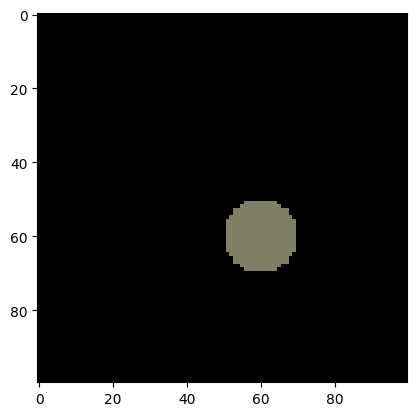

In [284]:
plt.imshow(img)

In [225]:
def get_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(3, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.Flatten())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(10, activation="relu"))
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(units=2, activation="softmax"))

    model.compile(**compile_kwargs)
    return model

In [198]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 32,
        "verbose": True,
        "callbacks": [callback],
    }

In [285]:
#Generate training data
def generate_training_data(sample_circle = 1000, sample_rectangle = 1000):
    X = []
    X_ood = []
    y = []
    
    
    for ii in tqdm(range(sample_circle)):
        center = 100*np.random.uniform(size=2)
        X.append(
            sim_circle(center, r=30, rgb=[127,127,127])
        )
        y.append(0)
    
    for ii in tqdm(range(sample_rectangle)):
        center = 100*np.random.uniform(size=2)
        X.append(
            sim_rectangle([30,40], w=50, h=20, rgb=[200,200,200])
        )
        y.append(1)
    
    
    X = np.array(X)

    return X, y

def get_ood(a, b, sample_ellipse = 100):
    for ii in tqdm(range(sample_ellipse)):
        center = 100*np.random.uniform(size=2)
        X_ood.append(
            sim_ellipse([60,60], a=a, b=b, rgb=[127,127,127])
        )
    
    X_ood = np.array(X_ood)
    return X_ood

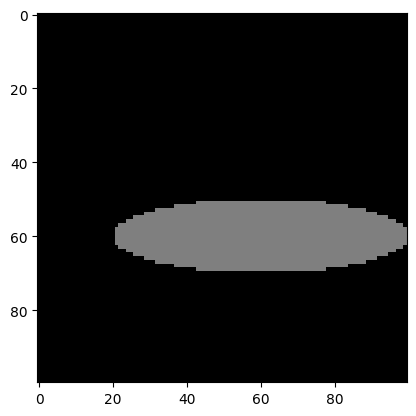

In [279]:
plt.imshow(X_ood[20])

In [207]:
cnn = get_cnn()
print(cnn.summary())
history = cnn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 98, 98, 3)         84        
                                                                 
 activation_24 (Activation)  (None, 98, 98, 3)         0         
                                                                 
 flatten_6 (Flatten)         (None, 28812)             0         
                                                                 
 activation_25 (Activation)  (None, 28812)             0         
                                                                 
 dense_12 (Dense)            (None, 10)                288130    
                                                                 
 activation_26 (Activation)  (None, 10)                0         
                                                                 
 dense_13 (Dense)            (None, 2)               

2024-02-11 15:02:26.229766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x2xi1>'
loc

63/63 [==============================] - 1s 11ms/step - loss: 1.6976
Epoch 2/200
11/63 [====>.........................] - ETA: 0s - loss: 0.0000e+00

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x16x1x2xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

63/63 [==============================] - 1s 10ms/step - loss: 0.0000e+00
Epoch 3/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 4/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 5/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0000e+00
Epoch 6/200
63/63 [==============================] - 1s 10ms/step - loss: 0.0000e+00
Epoch 7/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 8/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 9/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 10/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 11/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 12/200
63/63 [==============================] - 1s 9ms/step - loss: 0.0000e+00
Epoch 12: early stopping


In [244]:
model_kdn = kdcnn(
        network=cnn,
        output_layer='flatten_6'
    )
model_kdn.fit(X, y, k=1.2, batch=10)
    

63/63 [==============================] - 0s 3ms/step


2024-02-11 15:23:28.531009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]


Fitting data!


In [271]:
model_kdn.global_bias = -1e13

In [281]:
model_kdn.predict_proba(X_ood, distance='Geodesic')

4/4 [==============================] - 0s 10ms/step


2024-02-11 16:02:36.210874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.73it/s]


array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5,

In [286]:
model_kdn.polytope_cov

[array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dtype=float32),
 array([1.e-06, 1.e-06, 1.e-06, ..., 1.e-06, 1.e-06, 1.e-06], dt

In [ ]:
def experiment_delta(reps=20):
    res = []

    for ii in range(reps):
        print("Doing reps ", ii)
        
        tmp = []
        X, y = generate_training_data()
        cnn = get_cnn()
        model_kdn = kdcnn(
                        network=cnn,
                        output_layer='flatten_6'
                        )
        model_kdn.fit(X, y, k=1.2, batch=10)
        model_kdn.global_bias = -1e13
    
        for a in range(100,0,-10):
            X_ood = get_ood(a, 30, 10)
            proba = model_kdn.predict_proba(X_ood, distance='Geodesic')
            mean_max_proba = np.mean(np.max(proba, axis=1))
            tmp.append(mean_max_proba)
        res.append(tmp)

    return res
        